# HBV calibration

This notebook is used to predict future discharge values for the Loire river at Blois. For these prediction, different climate scenarios are used: SSP126, SSP2455 and SSP585. These discharge values are then analysed using the drought analyser (Drought_analyser.ipynb) to assess the difference between past and future. 

### 1. Importing general python modules

In [110]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import pandas as pd
import seaborn as sns

#niceties
from rich import print

# Needed
from ipywidgets import IntProgress
from IPython.display import display
from scipy.stats import qmc
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from statsmodels.distributions.empirical_distribution import ECDF

In [111]:
# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [112]:
# import drought analyser function
%run Drought_analyser.ipynb

### 2. Defining experiment data and paths 

In [113]:
# name of the catchment
basin_name = "FR003882"

# defining dates for calibration
historical_start_date = "1941-01-01"
historical_end_date = "2014-12-31"
future_start_data = "2026-01-01"
future_end_data = "2099-12-31"

# defining path for catchment shape file
station_shp = Path.home() / "BEP-Loire" / "book" / "model_loire" / "estreams_cb_FR003882.shp"

# defining destination path for ERA5 data
forcing_path_CMIP = Path.home() / "forcing" / "loire_river" / "CMIP"
forcing_path_CMIP.mkdir(exist_ok=True)

# model HBV destination path
model_path_HBV = Path.home() / "tmp" / "HBV_model" / "CMIP"
model_path_HBV.mkdir(exist_ok=True)

gdf = gpd.read_file("estreams_cb_FR003882.shp")
gdf = gdf.to_crs(epsg=2154)
gdf["area_km2"] = gdf.geometry.area / 1e6  
basin_area = gdf["area_km2"].sum()

### 3. Load generated CMIP forcings

In [114]:
# Load historical data
historic_location = forcing_path_CMIP / "Historical" / "work" / "diagnostic" / "script" 
HIST = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=historic_location)

# Load SSP126 data
ssp126_location = forcing_path_CMIP / "SSP126_2699" / "work" / "diagnostic" / "script" 
SSP126 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=ssp126_location)

# Load SSP245 data
ssp245_location = forcing_path_CMIP / "SSP245_2699" / "work" / "diagnostic" / "script" 
SSP245 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=ssp245_location)

# Load SSP585 data
ssp585_location = forcing_path_CMIP / "SSP585_2699" / "work" / "diagnostic" / "script" 
SSP585 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=ssp585_location)

### 4. Setting up the model (HBV)

In [115]:
# Good parameters distribution calibration (N = 2000)
params = [
    6.382012946132834,
    0.6365395937132804,
    366.6921134386536,
    3.275414443053375,
    0.22241595560479888,
    9.260634181675487,
    0.09034248156803193,
    0.0003441943533997508,
    0.026098858621656
]

# Starting values for model storages
#                Si,    Su,  Sf,    Ss,  Sp
s_0 = np.array([5.3, 249.8, 2.4, 372.5, 2.9])

### 5. Running the model

In [13]:
forcing_list = [HIST, SSP126, SSP245, SSP585]
output = []
years = []

for forcings in forcing_list:
    model = ewatercycle.models.HBV(forcing=forcings)
    config_file, _ = model.setup(
        parameters=params, 
        initial_storage=s_0,
        cfg_dir = model_path_HBV,
    )

    model.initialize(config_file)

    Q_m = []
    time = []
    
    while model.time < model.end_time:
        model.update()
        Q_m.append(model.get_value("Q")[0])
        time.append(pd.Timestamp(model.time_as_datetime))
        
    output.append(Q_m)
    years.append(time)
    
    del Q_m, time
    model.finalize()

### 6. Get results

(0.0, 200.0)

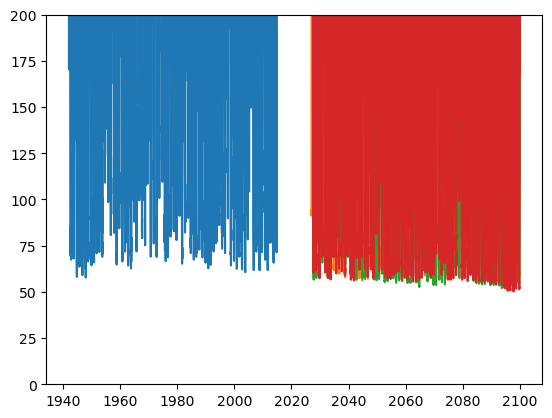

In [116]:
# Load output data
historical_output = pd.Series(data=output[0], name="Historical", index=years[0])["1942-01-01":]
SSP126_output = pd.Series(data=output[1], name="SSP126", index=years[1])["2027-01-01":]
SSP245_output = pd.Series(data=output[2], name="SSP245", index=years[2])["2027-01-01":]
SSP585_output = pd.Series(data=output[3], name="SSP585", index=years[3])["2027-01-01":]


# Convert mm/d to m3/s
factor = basin_area / 86.4
historical_output *= factor
SSP126_output *= factor
SSP245_output *= factor
SSP585_output *= factor

plt.plot(historical_output)
plt.plot(SSP126_output)
plt.plot(SSP245_output)
plt.plot(SSP585_output)
plt.ylim((0, 200))

### 7. Drought analyser

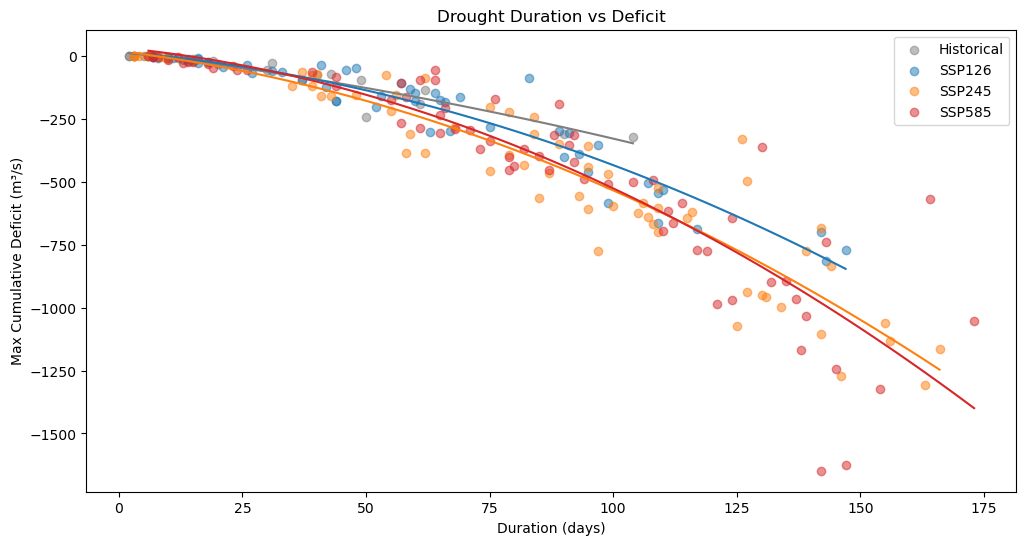

In [117]:
# Run drought analyser
historical_droughts = drought_analyser(historical_output, '', 66.5)
SSP126_droughts = drought_analyser(SSP126_output, '', 66.5)
SSP245_droughts = drought_analyser(SSP245_output, '', 66.5)
SSP585_droughts = drought_analyser(SSP585_output, '', 66.5)

xh, yh = historical_droughts["Duration (days)"], historical_droughts["Max Cumulative Deficit (m3/s)"]
x1, y1 = SSP126_droughts["Duration (days)"], SSP126_droughts["Max Cumulative Deficit (m3/s)"]
x2, y2 = SSP245_droughts["Duration (days)"], SSP245_droughts["Max Cumulative Deficit (m3/s)"]
x5, y5 = SSP585_droughts["Duration (days)"], SSP585_droughts["Max Cumulative Deficit (m3/s)"]


# Functie voor polyfit en plot
def plot_droughts(x, y, color, label):
    coeffs = np.polyfit(x, y, 2)
    poly_func = np.poly1d(coeffs)
    
    x_smooth = np.linspace(x.min(), x.max(), 100)
    y_smooth = poly_func(x_smooth)
    
    plt.scatter(x, y, color=color, alpha=0.5, label=label)
    plt.plot(x_smooth, y_smooth, color=color)

plt.figure(figsize=(12, 6))

# Data plotten met behulp van de functie
plot_droughts(xh, yh, "#7f7f7f", "Historical")
plot_droughts(x1, y1, "#1f77b4", "SSP126")
plot_droughts(x2, y2, "#ff7f0e", "SSP245")
plot_droughts(x5, y5, "#d62728", "SSP585")

plt.title('Drought Duration vs Deficit')
plt.xlabel('Duration (days)')
plt.ylabel('Max Cumulative Deficit (m³/s)')
plt.legend()
plt.show()

### 8. Distribution

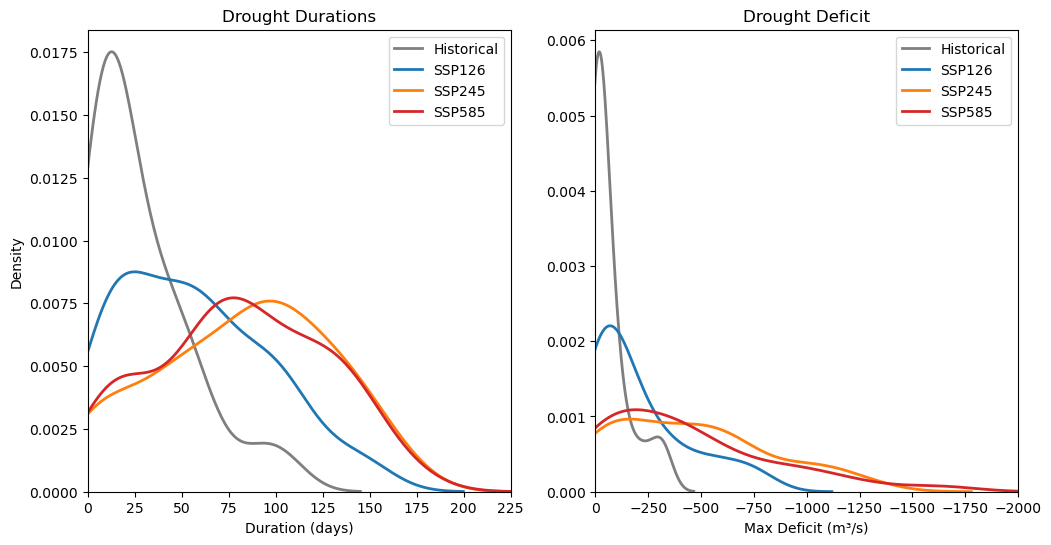

In [118]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot 1: Duration
plt.subplot(1, 2, 1)
sns.kdeplot(xh, label='Historical', color="#7f7f7f", linewidth=2)
sns.kdeplot(x1, label='SSP126', color="#1f77b4", linewidth=2)
sns.kdeplot(x2, label='SSP245', color="#ff7f0e", linewidth=2)
sns.kdeplot(x5, label='SSP585', color="#d62728", linewidth=2)
plt.title('Drought Durations')
plt.xlabel('Duration (days)')
plt.xlim(0, 225)
plt.legend()

# Plot 2: Deficit
plt.subplot(1, 2, 2)
sns.kdeplot(yh, label='Historical', color="#7f7f7f", linewidth=2)
sns.kdeplot(y1, label='SSP126', color="#1f77b4", linewidth=2)
sns.kdeplot(y2, label='SSP245', color="#ff7f0e", linewidth=2)
sns.kdeplot(y5, label='SSP585', color="#d62728", linewidth=2)
plt.title('Drought Deficit')
plt.xlabel('Max Deficit (m³/s)')
plt.ylabel('')
plt.xlim(-2000, 0)
plt.gca().invert_xaxis()
plt.legend()

### 9. Cumulative distribution

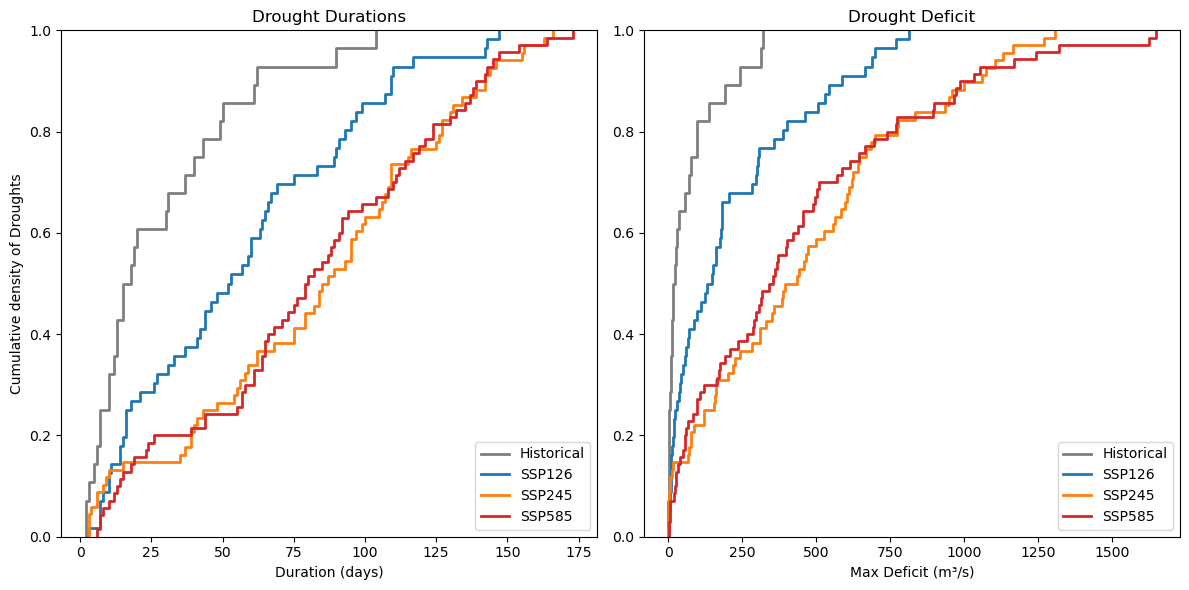

In [119]:
plt.figure(figsize=(12, 6))

# Plot 1: Duration
plt.subplot(1, 2, 1)
sns.ecdfplot(xh, label='Historical', color="#7f7f7f", linewidth=2)
sns.ecdfplot(x1, label='SSP126', color="#1f77b4", linewidth=2)
sns.ecdfplot(x2, label='SSP245', color="#ff7f0e", linewidth=2)
sns.ecdfplot(x5, label='SSP585', color="#d62728", linewidth=2)
plt.title('Drought Durations')
plt.xlabel('Duration (days)')
plt.ylabel('Cumulative density of Droughts')
plt.legend(loc='lower right')

# Plot 2: Deficit
plt.subplot(1, 2, 2)
sns.ecdfplot(yh*-1, label='Historical', color="#7f7f7f", linewidth=2)
sns.ecdfplot(y1*-1, label='SSP126', color="#1f77b4", linewidth=2)
sns.ecdfplot(y2*-1, label='SSP245', color="#ff7f0e", linewidth=2)
sns.ecdfplot(y5*-1, label='SSP585', color="#d62728", linewidth=2)
plt.title('Drought Deficit')
plt.xlabel('Max Deficit (m³/s)')
plt.ylabel('')
#plt.gca().invert_axis()
plt.legend()

plt.tight_layout()
plt.show()

### 10. Return period

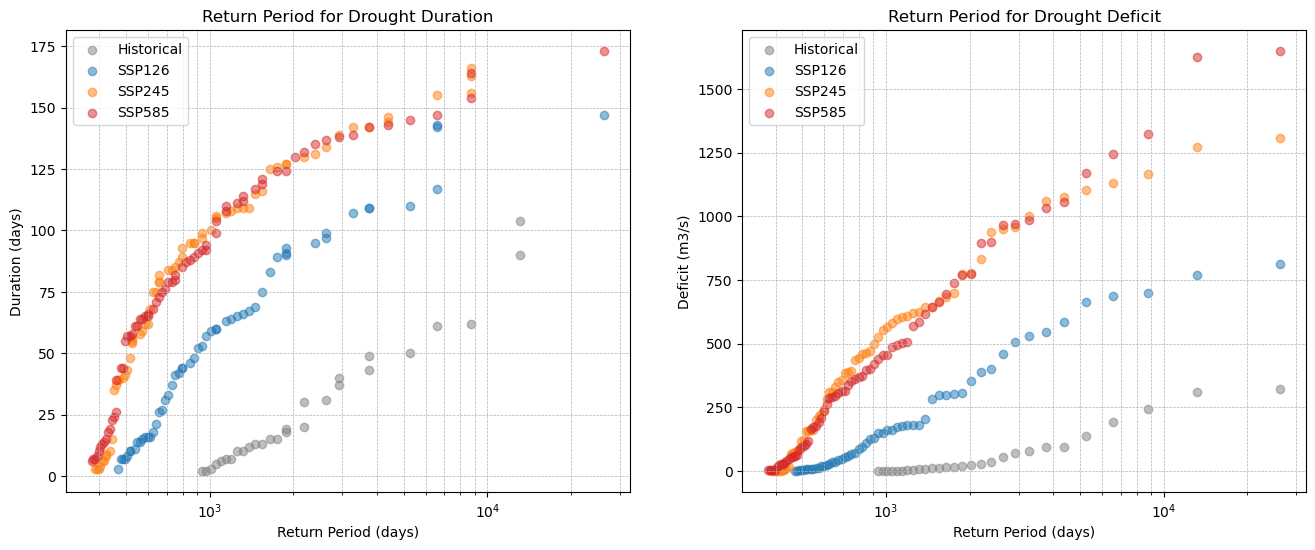

In [120]:
def plot_return_period(data, years, color, label):
    sorted_data = np.sort(data)
    N = years * 365
    n = len(sorted_data)

    # Emperical cumulative distribution
    ecdf = ECDF(sorted_data)
    F = ecdf(sorted_data)[::-1]

    # Return Period
    return_period = N / (n * (F))

    # Plot
    plt.scatter(return_period, sorted_data, color=color, alpha=0.5, label=label)

# Plot
plt.figure(figsize=(16, 6))

# Duration
plt.subplot(1, 2, 1)
plot_return_period(xh, 72, "#7f7f7f", "Historical")
plot_return_period(x1, 72, "#1f77b4", "SSP126")
plot_return_period(x2, 72, "#ff7f0e", "SSP245")
plot_return_period(x5, 72, "#d62728", "SSP585")

plt.xscale('log')
plt.title('Return Period for Drought Duration')
plt.xlabel('Return Period (days)')
plt.ylabel('Duration (days)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Duration
plt.subplot(1, 2, 2)
plot_return_period(yh*-1, 72, "#7f7f7f", "Historical")
plot_return_period(y1*-1, 72, "#1f77b4", "SSP126")
plot_return_period(y2*-1, 72, "#ff7f0e", "SSP245")
plot_return_period(y5*-1, 72, "#d62728", "SSP585")

plt.xscale('log')
plt.title('Return Period for Drought Deficit')
plt.xlabel('Return Period (days)')
plt.ylabel('Deficit (m3/s)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()


plt.show()